## Detecting Lane Lines on the Road

---

Prof. Dr.-Ing. Antje Muntzinger, Hochschule für Technik Stuttgart

antje.muntzinger@hft-stuttgart.de

---

**NOTE:** You may answer in English or German.

The following notebook is based on Udacity's *Self-Driving Car Nanodegree*.

In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "final-result-example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below to display the image.

In [54]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


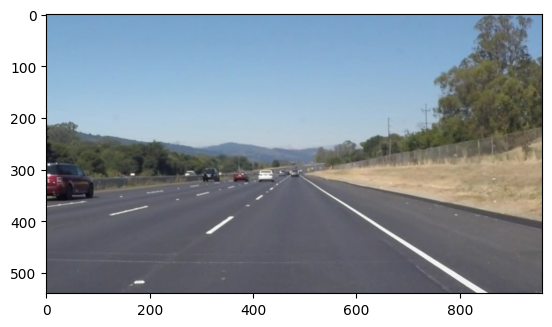

In [55]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  
plt.show()

## 1. Detect Line Segments using Canny and Hough

The first goal is to detect white or yellow lane markings. The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Transform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image. Your output should look something like this after detecting line segments:


<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">  </p> 
 </figcaption>
</figure>

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  

`cv2.fillPoly()` for regions selection  

`cv2.line()` to draw lines on an image given endpoints  

`cv2.addWeighted()` to coadd / overlay two images 

`cv2.cvtColor()` to grayscale or change color 

`cv2.imwrite()` to output images to file  

`cv2.bitwise_and()` to apply a mask to an image 

**Check out the OpenCV documentation to learn about these!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [56]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

**TODO:** 1) Build a pipeline to detect line segments using Canny edge detection and Hough transform. Run your solution on all test_images.
Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters. Plot the edges, Hough lines and detected lane segments in each image.

In [57]:
def grayscale(img):
    """Convert image to grayscale"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Apply Canny edge detection"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Apply Gaussian blur to reduce noise"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def weighted_img(img, initial_img, alpha=0.8, beta=1.):
    return cv2.addWeighted(initial_img, alpha, img, beta, 0)

In [58]:
def hough_pipeline(img,
                   kernel=5,
                   canny_low=50,
                   canny_high=150,
                   rho=1,
                   theta=np.pi/180,
                   threshold=20,
                   min_line_len=20,
                   max_line_gap=15,
                   plot=False,
                   title=None):
    """
    Full Hough pipeline for a single image.

    Parameters
    ----------
    img : ndarray (H,W,3)
        Input RGB image.
    kernel, canny_low, canny_high, rho, theta, threshold, min_line_len, max_line_gap
        Usual hyper-parameters for blur, Canny and Hough.
    plot : bool, optional
        If True, show a 1×3 figure with all intermediate results.

    Returns
    -------
    masked      : ndarray (H,W)
        Masked Canny edges (binary image).
    lines_img   : ndarray (H,W,3)
        Blank RGB canvas with the raw Hough segments drawn.
    lines       : ndarray (N,1,4)  or empty list
        Raw Hough-line output from cv2.HoughLinesP.
    """
    # --- 1  Gray + Blur + Canny ------------------------------------------------
    gray    = grayscale(img)
    blurred = gaussian_blur(gray, kernel)
    edges   = canny(blurred, canny_low, canny_high)

    # --- 2  ROI mask -----------------------------------------------------------
    h, w = img.shape[:2]
    polygon = np.array([[
        (w * 0.10, h),               # bottom-left
        (w * 0.45, h * 0.60),        # top-left
        (w * 0.55, h * 0.60),        # top-right
        (w * 0.90, h)                # bottom-right
    ]], dtype=np.int32)
    masked = region_of_interest(edges, polygon)

    # --- 3  Hough transform ----------------------------------------------------
    lines_img, lines = hough_lines(masked, rho, theta,
                                   threshold, min_line_len, max_line_gap)

    if lines is None:
        # Grace-fall: no segments detected
        print("Hough lines detection failed!")
        lines_img = np.zeros_like(img)
        lines = []          # empty list signals “no lines”

    # --------------------------------------------------------------------------
    #  Optional visualisation
    # --------------------------------------------------------------------------
    if plot:

        # Arrange axes and global paddings
        plt.subplots_adjust(left=0.1, bottom=0.1,
                            right=0.9, top=0.9,
                            wspace=0.4, hspace=0.4)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # Optional figure title
        if title is not None:
            fig.suptitle(title, fontsize=16, y=0.8, ha='center', va='center', x=0.5)

        # 0 – Original frame
        axes[0].set_title('original')
        axes[0].imshow(img)

        # 1 – Masked Canny edges
        axes[1].set_title('masked edges')
        axes[1].imshow(masked, cmap='gray')

        # 2 – Raw Hough segments over edges
        color_edges = np.dstack((masked, masked, masked))
        lines_edges = weighted_img(lines_img, color_edges)
        axes[2].set_title('Hough')
        axes[2].imshow(lines_edges)

        plt.show()

    # --------------------------------------------------------------------------
    return masked, lines_img, lines

<Figure size 640x480 with 0 Axes>

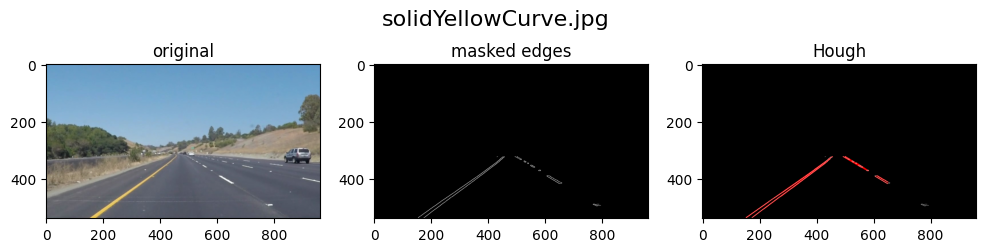

<Figure size 640x480 with 0 Axes>

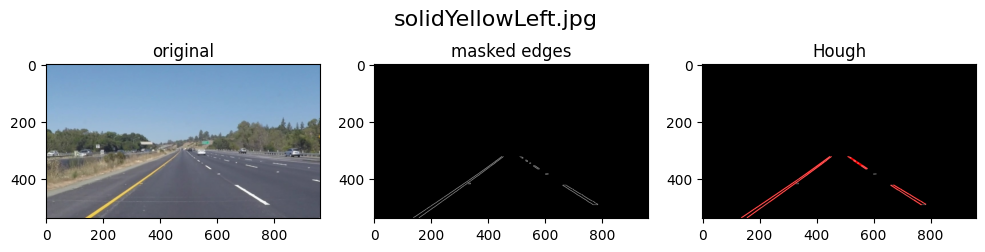

<Figure size 640x480 with 0 Axes>

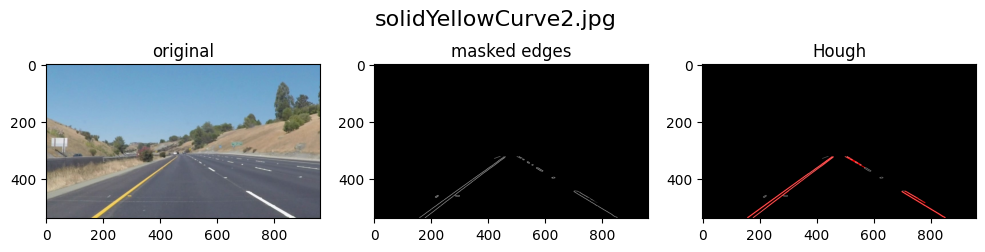

<Figure size 640x480 with 0 Axes>

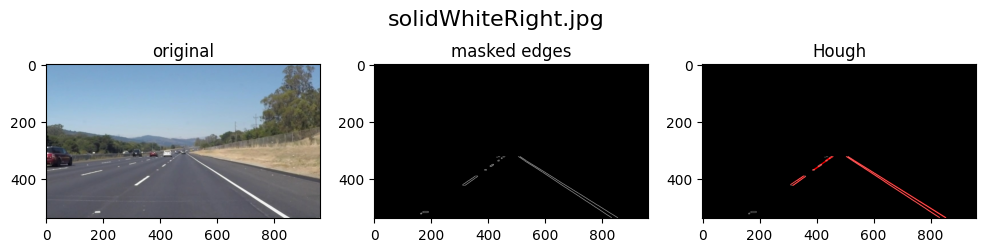

<Figure size 640x480 with 0 Axes>

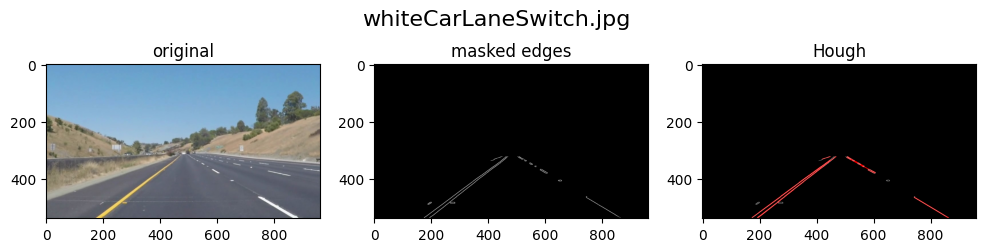

<Figure size 640x480 with 0 Axes>

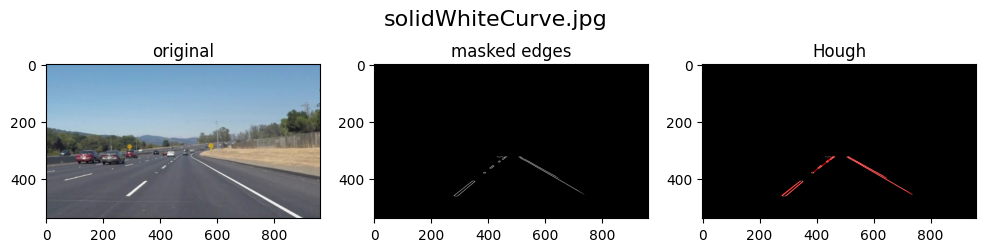

In [59]:
# batch process all test images
for img_path in os.listdir("test_images/"):
    img = mpimg.imread(f"test_images/{img_path}")
    masked, lines_img, lines = hough_pipeline(img, plot=True, title=img_path)

## 2. Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [60]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

**TODO:** 2a) Implement the `process_image` function below: It should call your hough pipeline on each image and return an image where the hough results are visible in the original photo. **(2 points)**

In [61]:
def process_image(image):
   
    (e, line_image, l) = hough_pipeline(image) 
    lines_edges = weighted_img(line_image,image)
    
    return lines_edges

In [62]:
# Optional:
# This code will create the output directory if it doesn't exist. Non-existence causes a runtime error at least on my end. Michael.

output_directory = "test_videos_output"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

Let's try the one with the solid white lane on the right first ...

In [63]:
# white_output = 'test_videos_output/solidWhiteRight.mp4'
white_output = os.path.join(output_directory, "solidWhiteRight.mp4")
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 725 ms, sys: 459 ms, total: 1.18 s
Wall time: 1.12 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [65]:
# yellow_output = 'test_videos_output/solidYellowLeft.mp4'
yellow_output = os.path.join(output_directory, "solidYellowLeft.mp4")
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 2.39 s, sys: 1.48 s, total: 3.87 s
Wall time: 3.83 s


In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

**TODO:** 2b) How do you interpret your video results? How is the overall performance, do you see some remaining problems? **(1 point)**

**ANSWER:**

Die durchgezogene Seitenlinie wird immer sehr gut erkannt, die gestrichelten Linien erkennt der Prozess momentan noch sehr Lückenhaft. Links außen wird auch selten der Übergang zum Vegetationsstreifen als Linie erkannt.
Beim Erreichen der Kurve am Ende des Videos deutet sich auch an, dass die Kurve noch eine Herausforderung werden könnte.

## 3. Interpolating Line Segments 

At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (final-result-example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. Try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "final-result-example.mp4".

Your output should now look something like this after detecting line segments:

<figure>
 <img src="examples\\line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">  </p> 
 </figcaption>
</figure>
 <p></p> 
Now the next goal is to connect/average/extrapolate line segments to get output like this:
<figure>
 <img src="examples\\laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> </p> 
 </figcaption>
</figure>
    



**TODO:** 3) Complete the code below. 
    
a) Complete the function `get_y_intercept_slope` by calculating the average y-intercept and slope of all inputs
    
b) Complete the function `get_x` by calculating the x-coordinates of $y_1$ and $y_2$.
    
**(6 points)**


In [67]:
# Get average y-intercept and average slope of the lines
def get_y_intercept_slope(lane_lines, slopes):
    '''Inputs:
    lane_lines: array of lines detected by Hough transform
    slopes: array of slopes of the lines detected by Hough transform
    Outputs:
    avg_intercept: average y-intercept of the lines
    avg_slope: average slope of the lines
    '''

    # Remove NaN and Inf values from slopes
    # slopes = slopes[~np.isnan(slopes)]
    # slopes = slopes[~np.isinf(slopes)]
    # Remove invalid slopes
    valid_mask = (~np.isnan(slopes)) & (~np.isinf(slopes))
    slopes = slopes[valid_mask]
    lane_lines = lane_lines[valid_mask] # wenn wir slopes für Senkrechten und Waagrechten aus der Liste entfernen, dann auch die zugehörigen Linien

    # Reshape the lines from (N, 4) to (N*2, 2)
    # where N is the number of lines and 4 is the number of coordinates for each line
    # The first two coordinates are the start points and the last two are the end points: (x1, y1, x2, y2)
    # The reshape will give us (N*2, 2) where the first column is x and the second column is y
    #lane_lines = lane_lines.reshape((lane_lines.shape[0]*2, lane_lines.shape[1]//2)) 
    # -> für die Durchschnittsberechnung verstehen wir das reshape in eine Punkteliste nicht.

    x1_coords = lane_lines[:, 0] # Alle x1-Koordinaten der gefilterten Linien
    y1_coords = lane_lines[:, 1] 
    
    y_intercepts = y1_coords - slopes * x1_coords
    avg_slope = np.mean(slopes)
    # print("average slope:", avg_slope)
    avg_intercept = np.mean(y_intercepts)
    # print("average intercept:", avg_intercept)

    return avg_intercept, avg_slope

# Get x values for a line given y values, slope and y-intercept
def get_x(y_1, y_2, slope, b):
    '''Inputs:
    y_1: y-coordinate of the first point
    y_2: y-coordinate of the second point
    slope: slope of the line
    b: y-intercept of the line
    Outputs:    
    x_1: x-coordinate of the first point
    x_2: x-coordinate of the second point
    '''

    # Guard against NaN and Inf values
    if np.isnan(slope) or np.isnan(b) or np.isinf(slope) or np.isinf(b):
        # If slope or y-intercept is NaN or Inf, return 0
        x_1 = x_2 = 0.0
    else:
        x_1 = (y_1-b)/slope
        x_2 = (y_2-b)/slope
    
    return x_1, x_2

In [68]:
# Function to extrapolate detected Hough lines
def extrapolate_lines(img, lines, plot=True, color=[255, 0, 0], thickness=10):
    img_hough_lines_extrapolated = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) # Create a blank image

    lines = lines.reshape((lines.shape[0], lines.shape[2])) # Reshape to 2D array of x1,y1,x2,y2
    y_min = lines.reshape((lines.shape[0]*2, lines.shape[1]//2))[:,1].min() # Get the minimum y value from all lines

    # Get the slopes of the lines
    # slope= (    y2      -     y1   )/(    x2     -     x1    )  
    slopes = (lines[:,3] - lines[:,1])/(lines[:,2] - lines[:,0]) # Calculate slope for each line
    slopes = slopes[~np.isinf(slopes)]
    slopes = slopes[~np.isnan(slopes)]
    
    # Get the left and right lines based on slope
    left_lines = lines[slopes < -0.5]   # Left  lines should have negative slope, threshold=-0.5 (because y-axis is inverted)
    right_lines= lines[slopes > 0.5]   # Right lines should have positive slope, threshold=+0.5
    left_slopes = slopes[slopes < -0.5]
    right_slopes= slopes[slopes > 0.5]
    
    # Get average y-intercept and average slope
    left_b, left_avg_m = get_y_intercept_slope(left_lines, left_slopes) 
    right_b, right_avg_m = get_y_intercept_slope(right_lines, right_slopes)

    # using y_min, avg_slope and y_intercept find points x1, x2 that will be used to draw the lines
    left_x1, left_x2 = get_x(y_1=y_min, y_2=img_hough_lines_extrapolated.shape[0], slope=left_avg_m, b=left_b)
    right_x1, right_x2 = get_x(y_1=y_min, y_2=img_hough_lines_extrapolated.shape[0], slope=right_avg_m, b=right_b)

    # Draw the lines 
    cv2.line(img_hough_lines_extrapolated, (int(left_x1), int(y_min)), (int(left_x2), img_hough_lines_extrapolated.shape[0]), color, thickness)
    cv2.line(img_hough_lines_extrapolated, (int(right_x1), int(y_min)), (int(right_x2), img_hough_lines_extrapolated.shape[0]), color, thickness)

    # Add extrapolated Hough lines to original image
    # the result image is computed as follows:
    # initial_img * alpha + img * beta + gamma
    alpha=0.8
    beta=1.
    gamma=0.
    img_lanes_extrapolated = cv2.addWeighted(img_hough_lines_extrapolated, alpha, img, beta, gamma)
    if plot:
        plt.imshow(img_lanes_extrapolated)
        plt.show()
    # ------------------------------------------------------
    # Modified code to return the extrapolated lines
    # ------------------------------------------------------
    extrapolated_lines = np.array([[left_x1,  y_min, img.shape[0], left_x2],
                               [right_x1, y_min, img.shape[0], right_x2]],
                              dtype=float)

    return img_lanes_extrapolated, extrapolated_lines

<Figure size 640x480 with 0 Axes>

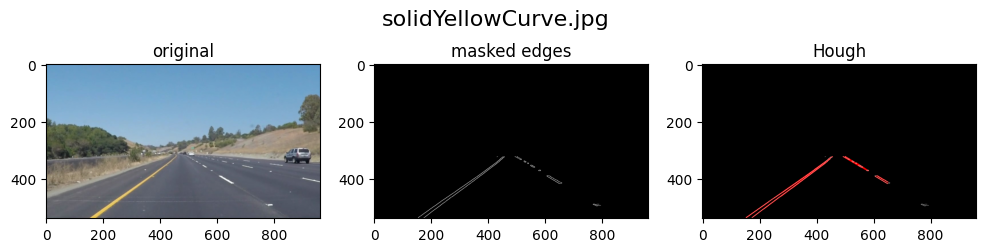

Line segments detected using Hough transform: 18


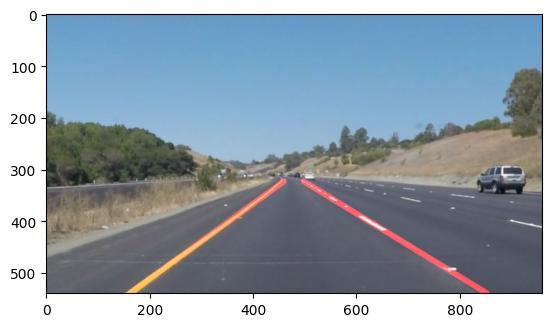

Line segments extrapolated:
 [[460.29803725 324.         540.         162.48755999]
 [498.91904812 324.         540.         853.16077398]]


<Figure size 640x480 with 0 Axes>

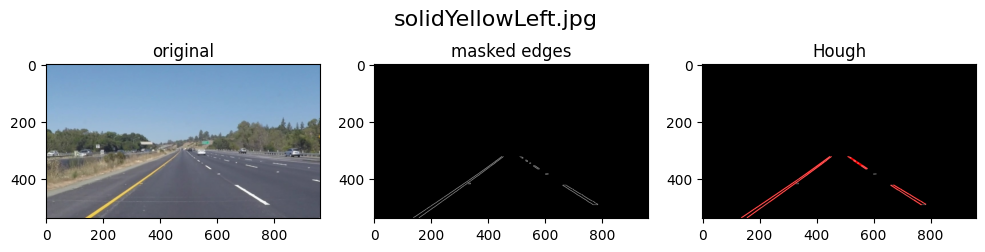

Line segments detected using Hough transform: 20


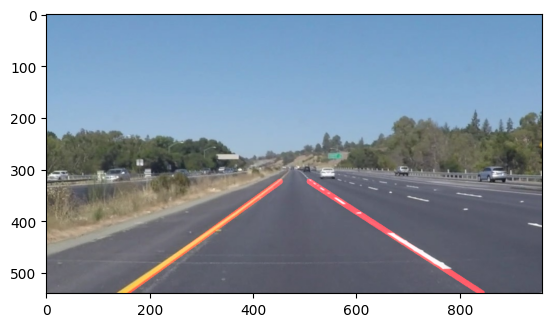

Line segments extrapolated:
 [[453.07522914 324.         540.         153.65471613]
 [509.40886093 324.         540.         844.87416928]]


<Figure size 640x480 with 0 Axes>

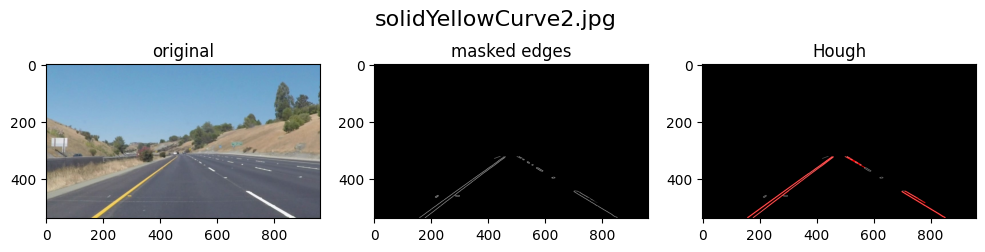

Line segments detected using Hough transform: 15


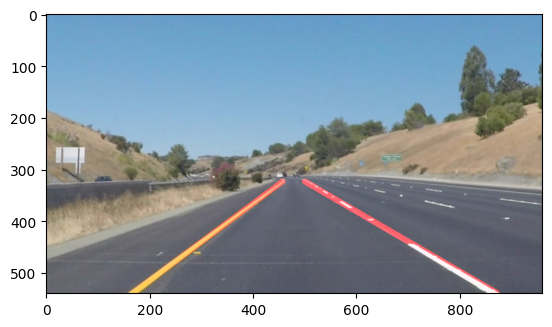

Line segments extrapolated:
 [[458.90528686 324.         540.         167.75724827]
 [500.28670676 324.         540.         873.77845281]]


<Figure size 640x480 with 0 Axes>

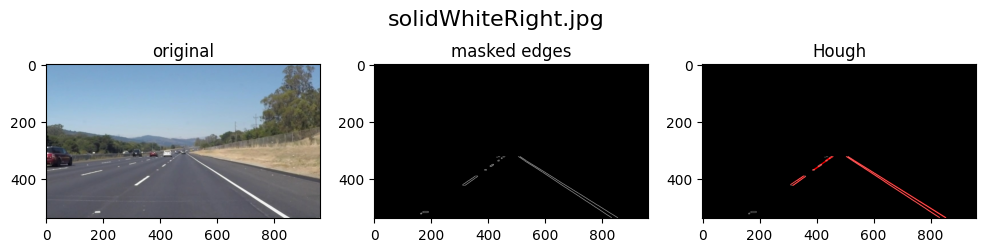

Line segments detected using Hough transform: 14


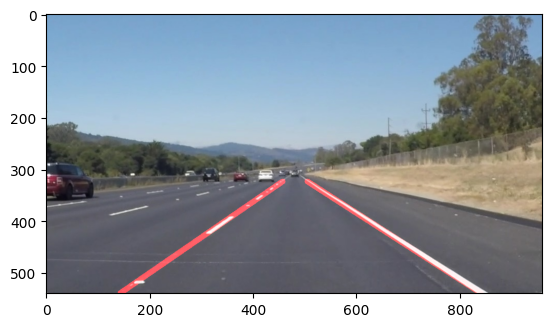

Line segments extrapolated:
 [[458.2882047  324.         540.         143.21478486]
 [505.16821002 324.         540.         842.56606612]]


<Figure size 640x480 with 0 Axes>

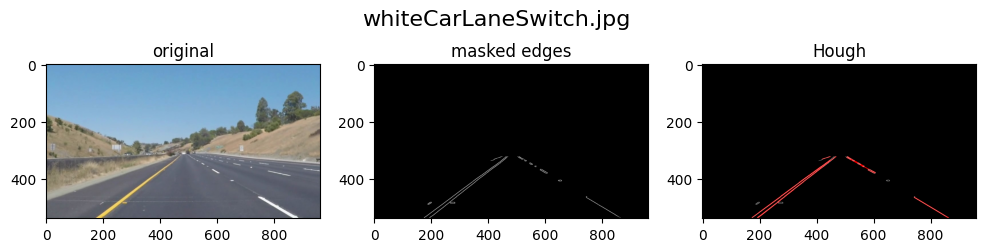

Line segments detected using Hough transform: 19


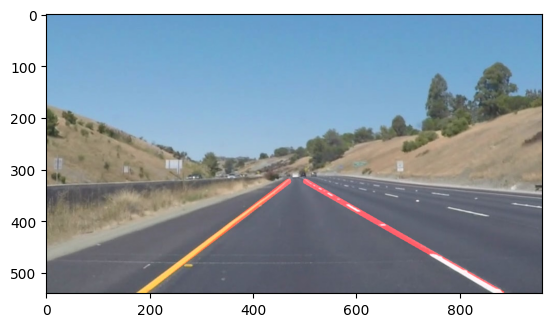

Line segments extrapolated:
 [[469.1387532  324.         540.         184.45540295]
 [502.9452617  324.         540.         882.653396  ]]


<Figure size 640x480 with 0 Axes>

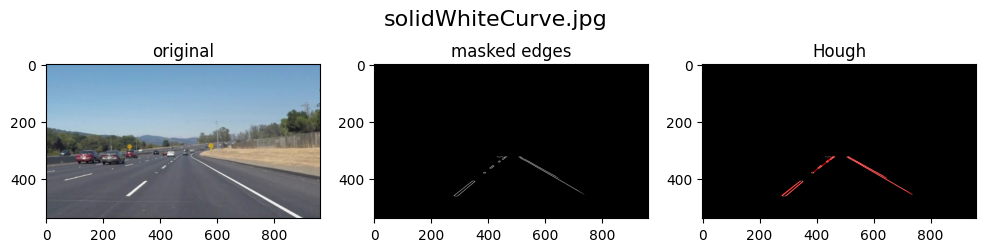

Line segments detected using Hough transform: 14


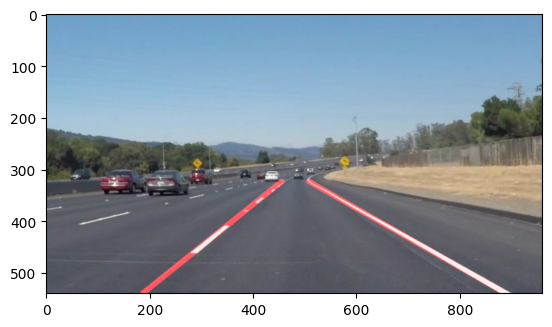

Line segments extrapolated:
 [[456.7329688  324.         540.         187.29051483]
 [508.64979586 324.         540.         889.53266182]]


In [69]:
# Loop over test images and apply the pipeline
for img_name in os.listdir("test_images/"):
    #print("Processing image: ", img_name)
    img = mpimg.imread("test_images/" + img_name)
    img_masked_edges, img_lanes, lines = hough_pipeline(img, plot=True, title=img_name)
    print("Line segments detected using Hough transform:", len(lines))
    img_lanes_extrapolated, extr_lines = extrapolate_lines(img, lines, plot=True, color=[255, 0, 0], thickness=10)
    print("Line segments extrapolated:\n", extr_lines)
    

## 4. Generating Improved Videos

As before, test your solution on the two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [70]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

**TODO:** 4a) Implement the `process_image_extrapolated` function below: It should call your hough pipeline on each image and return an image where the extrapolated hough results are visible in the original photo. **(3 points)**

In [71]:
# Function to process each frame of the video
def process_image_extrapolated(img):
    """
    Run full lane-detection pipeline on a single RGB frame and return
    the frame overlaid with the extrapolated lane lines.

    Parameters
    ----------
    img : ndarray (H, W, 3)
        Input RGB image.

    Returns
    -------
    img_lanes_extrapolated : ndarray (H, W, 3)
        Output image where the extrapolated Hough lines are visible
        on the original photo.
    """
    # ---------------------------------------------------------------
    # 1) Detect edges + Hough line segments (no plotting for speed)
    # ---------------------------------------------------------------
    _, _, lines = hough_pipeline(img, plot=False)

    # ---------------------------------------------------------------
    # 2) Extrapolate the two lane lines and overlay them onto img
    #    extrapolate_lines returns (overlay_img, coordinates)
    # ---------------------------------------------------------------
    img_lanes_extrapolated, _ = extrapolate_lines(img, lines, plot=False, color=[255, 0, 0], thickness=10)

    # ---------------------------------------------------------------
    return img_lanes_extrapolated

Let's try the one with the solid white lane on the right first ...

In [72]:
white_output2 = 'test_videos_output/solidWhiteRight2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip2 = clip3.fl_image(process_image_extrapolated) #NOTE: this function expects color images!
%time white_clip2.write_videofile(white_output2, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight2.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight2.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight2.mp4
CPU times: user 782 ms, sys: 508 ms, total: 1.29 s
Wall time: 1.3 s


In [73]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output2))



And the one with the solid yellow lane on the left:

In [74]:
yellow_output2 = 'test_videos_output/solidYellowLeft2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip4 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip4 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip2 = clip4.fl_image(process_image_extrapolated)
%time yellow_clip2.write_videofile(yellow_output2, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft2.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft2.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft2.mp4
CPU times: user 2.53 s, sys: 1.68 s, total: 4.21 s
Wall time: 3.96 s


In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output2))

**TODO:** 4b) How do you interpret your video results? How is the overall performance, do you see some remaining problems? **(1 point)**

**ANSWER:**
In den meisten Frames sind beide extrapolierten Linien durchgezogen vom unteren Bildrand, aber nur bis knapp unter den Horizont. Hier ist wahrscheinlich die Deckelung mit `y_min` zu niedrig.

Außerdem zittern die Linien stark, was darauf hindeutet, dass die Zahl und Lage der Hough-Segmente von Bild zu Bild variiert und damit der Mittelwert springt.

Bei `yellow_output2` lassen sich am Ende Schwierigkeiten mit der darauffolgenden Kurve erahnen. 

Insgesamt liefert die Pipeline aber bereits überzeugende Resultate in Standardsituationen.

## 5. Reflections

**TODO:** 5) Congratulations on finding the lane lines!  As the final step in this project, please share your thoughts on your lane finding pipeline. Specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail? Please add your thoughts below! **(2 points)**


**ANSWER:**

Wie in den Vorlesungenfolien beschrieben könnte man ein Gradient-basiertes Voting in der Hough-Pipeline verwenden. Dazu verwendet man die Gradientenrichtung jedes Kantenpixels, um beim Hough-Voting nur noch einen einzigen Winkel θ zuzulassen - nämlich den, der senkrecht zum lokalen Gradienten steht. Damit spart man sich unnötiges Voting und ein Pixel mit richtiger Spurmarkierung stimmt damit nur genau mit dem korrekten Winkel.

Störkanten haben meist eine andere Gradientenrichtung --> diese Stimmen werden damit weitestgehend eliminiert. 

Das dürfte gegen das Zittern der extrapolierten Linien helfen.

Auch könnte man starken Kanten mehr Votes geben, damit sie stärker ins Gewicht fallen. 


**NOTE:** Converting this Jupyter Notebook to pdf is difficult due to the videos, so it is sufficient to submit the .ipynb file for this project.